# CSE252C: Homework 2
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Thu, May 21, at 4pm. 

## Q1: Using SphereFace [3] for Face Verification

1. In the first section, we will test a pretrained model of SphereFace on LFW [4] dataset. The LFW dataset is on `/datasets/cse152-252-sp20-public/hw2_data/lfw`. The dataset contains 6000 pairs of human face images with ground truth labels for whether they are from the same identity.
2. The PyTorch code of SphereFace is located in `./sphereFace`, which is modified based on the open source code from `https://github.com/clcarwin/sphereface_pytorch`. 
3. Run the following commands and report the accuracy of SphereFace on LFW verification. **(5 points)**
```
cd sphereFace
tar -zxf model.tar.gz
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

``Answer here.``

LFWACC=0.9918 std=0.0051 thd=0.3095

4. Explain briefly how the following steps are performed when evaluating on LFW dataset: 
    1. Given the features extracted from the network, what is the metric used to measure the distance between two faces? (`lfw_eval.py`: Line 135) **(5 points)**
    2. How is the threshold set to determine whether two faces are from the same identity? How is the accuracy computed? (`lfw_eval.py`: Line 141 to 148) **(10 points)**

``Answer here.`` <br>

A. cosdistance (cosine of angle between f1 and f2 image vectors)
B. Different threshold value from -1 to 1 with 0.005 step sizes are tried. The threshold value that give best best accuracy is selected. Accuracy is calculate but ratio of correct matches over total number of samples. num(y_true==y_predict) / num(y_true) # total number

5. An important step before face recognition is face alignment, in which we warp and crop the image based on the location of facial landmarks.
    1. Briefly describe how we warp and crop the image. (`lfw_eval.py`: Line 11-26) **(5 points)**
    2. Instead of doing face alignment, crop an image patch of height 112 pixels and width 96 pixels at the center of the image. Report the accuracy.  **(10 points)**

``Answer here.`` <br>

A. using 5 point-correspondances between source and reference image we calculate the transformation matrix. We use the trasformation matrix to warp. We crop a window of size 96$\times$122 around the face.(____ points)

B. Accuracy is screwed!. Thus alignment is very important.

## Q2: Using MTCNN [5] for Detecting Face Landmarks

1. Instead of using provided facial landmarks, we will now use MTCNN [5](Multi-task Cascade Convolutional network) for detecting them. The code is located at `./mtcnn`. Run the following commands to generate the facial landmarks. Include two example outputs in your report. **(5 points)**
```
cd MTCNN 
python lfw_landmark.py --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

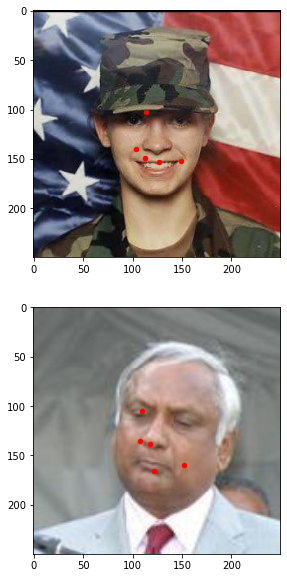

In [44]:
def keypointParser(keypoints):
    x,y = [],[]
    points = keypoints.split('\t')
    for i in range(5):
        x.append(float(points[i]))
        y.append(float(points[i+5]))   
    return x, y
        
keypoints_jessica ="103.060	113.257	148.525	112.080	126.244	140.406	102.061	152.580	149.051	152.750"
keypoints_satnarine = "107.769	109.772	151.811	117.126	122.042	135.389	104.963	159.287	137.990	166.214"
x1,y1 = parser(keypoints_jessica)
x2,y2 = parser(keypoints_satnarine)

import matplotlib.pyplot as plt
image_name1 = "./mtcnn/examples/Jessica_Lynch_0001.jpg"
image_name2 = "./mtcnn/examples/Satnarine_Sharma_0001.jpg"

f, axs = plt.subplots(2,1,figsize=(10,10))
plt.subplot(211)
im1 = plt.imread(image_name1)
plt.imshow(im1)
plt.scatter(x1, y1, c='r', s=20)
plt.subplot(212)

im2 = plt.imread(image_name)
plt.imshow(im2)
plt.scatter(x2, y2, c='r', s=20)

plt.show()

2. Go to the `sphereFace` directory, run the following commands by setting flag `alignmentMode` to be 2. Report the error using the predicted facial landmarks. **(5 points)**
```
cd sphereFace
python -W ignore::DeprecationWarning lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/ --alignmentMode 2
```

``Answer here.`` <br>
LFWACC=0.9845 std=0.0057 thd=0.2995

3. Next, answer the following questions:
    1. Is the result better than using the landmarks provided in the previous question? If not, how can you improve performance? **(5 points)**
    2.  What are the steps adopted by the method to achieve real-time speed? **(5 points)**
    3. Briefly describe how non-maximal suppression (NMS) is implemented in this method. (`src/box_utils.py`: Line 5-68) **(5 points)**

``Answer here.``

## Q3: Training SphereFace [3] on CASIA Dataset [6]

You will now train a network on the CASIA dataset [6] and test on the LFW dataset [4]. In this section, the skeleton code for training is given. CASIA-Webface dataset can be found at `/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace`.  
1. Go to directory of  `sphereFace` and open `faceNet.py`. Under class `CustomLinear` implement function $\psi$ as shown in Eq. (7) and Appendix G in [3], which is as follows. 
\begin{equation*}
\psi(\theta ) = (-1)^{k}\cos(m\theta )-2k, \quad \theta \in [\frac{k\pi}{m}, \frac{(k+1)\pi}{m}] \nonumber
\end{equation*}
Under class `CustomLoss`, implement the loss function. **(15 points)**

* Phi theta 
```python
cos_m_theta = self.mlambda[self.m](cos_theta)
theta = Variable(cos_theta.data.acos())
k = (self.m*theta/3.14159265).floor()
n_one = k*0.0 - 1
phi_theta = (n_one**k) * cos_m_theta - 2*k
```

* Custom loss

```python
index = cos_theta.data * 0.0 #size=(B,Classnum)
index.scatter(1,target.data.view(-1,1),1)
index = index.byte()
index = Variable(index)

self.lamb = max(self.LambdaMin,self.LambdaMax/(1+0.1*self.it ))
output = cos_theta * 1.0 #size=(B,Classnum)
output[index] -= cos_theta[index]*(1.0+0)/(1+self.lamb)
output[index] += phi_theta[index]*(1.0+0)/(1+self.lamb)

logpt = F.log_softmax(output, dim=1)
logpt = logpt.gather(1,target)
logpt = logpt.view(-1)

loss = -1 * logpt
loss = loss.mean()
```

2. Train the network using $\mathtt{casia\_train.py}$. You may try various hyperparameters like $m$, learning rate, batch size, training iterations and so on. Stop when you think the network behaves strangely (drop in accuracy, or loss stops decreasing). You may refer (and cite) any open source code (for example, \url{https://github.com/clcarwin/sphereface_pytorch}). Include the following in your report:
    1. Curves for training loss and accuracy on CASIA, which have been saved in the `checkpoint` directory (you may smooth the curves to make them look better). **(10 points)**
    2. Accuracy on the LFW dataset, evaluated using `lfw_eval.py`. You are expected to achieve accuracy higher than 90% on the LFW dataset. **(10 points)**

``Answer Here``
Used Default Parameters

B. LFWACC=0.9560 std=0.0115 thd=0.2295

3. The architecture above is a 20-layer residual network as described in Table 2 of [3], but without batch normalization. Now add batch normalization after every convolutional and fully connected layer. Train the new network on CASIA dataset and test on LFW dataset. Following is a demonstration of a residual block with 128 filters and kernel size $3\times3$:
\begin{align}
y &=& \mathtt{CONV}_{3\times3, 128}(x) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
y &=& \mathtt{CONV}_{3\times3, 128}(y) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
\mathtt{OUT} &=& x + y
\end{align}
    1. Draw the training curves for accuracy and loss on CASIA and compare to the curve without batch normalization. **(10 points)**
    2. Report accuracy on the LFW dataset, evaluated using `lfw_eval.py`. **(10 points)** <br>
    
    `python -W ignore::DeprecationWarning -W ignore::FutureWarning lfw_eval.py --model ./checkpoint/netBest-8.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/`
    
    3. Do you achieve better performance on LFW? If yes, explain how batch normalization helps. If not, try to explain why the results are worse.  **(10 points)**

``Answer here``

B. LFWACC=0.9415 std=0.0108 thd=0.6730

4. Randomly choose 10 identities from the CASIA dataset, forward pass all their images through the network and visualize the normalized features using tSNE \cite{maaten2008visualizing}. You can use code from \url{https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html} for visualization. Try a few random samples and include the figure that you consider most illustrative of the method. Retain the identities chosen here since they will be used again for the next question. **(10 points)**

``Answer here``

## Q4: Training CosFace [7] on CASIA Dataset [6]

In this section, you are required to implement CosFace based on the code you use in the previous section, train it on CASIA dataset and test on LFW dataset. 
1. Go to directory `./cosFace` and open `faceNet.py`. Again implement the function $\psi$ and the loss function of CosFace under `CustomLinear` and `CustomLoss` in `faceNet.py`. You may check (and duly cite) any open source implementation for hints on improving the performance. **(15 points)**

`python -W ignore::DeprecationWarning -W ignore::FutureWarning -W ignore::UserWarning casia_train.py --imageRoot /datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace --experiment checkpoint`

``Copy your implementation of CustomLinear and CustomLoss here`` <br>

* Phi theta 
```python
phi_theta = cos_theta - m
```

* Custom loss

```python
index = cos_theta.data * 0.0 #size=(B,Classnum)
index.scatter(1,target.data.view(-1,1),1)
index = index.byte()
index = Variable(index)

output = self.s * cos_theta * 1.0 #size=(B,Classnum)
output[index] -= self.s * cos_theta[index]
output[index] += self.s * phi_theta[index]

logpt = F.log_softmax(output, dim=1)
logpt = logpt.gather(1,target)
logpt = logpt.view(-1)

loss = -1 * logpt
loss = loss.mean()
```

2. Copy the 20-layer residual network with batch normalization you have written in the previous section to `faceNet.py`. Use that network structure for training and testing. Train the network on CASIA dataset. Again you are free to change any hyper parameters but report the hyper parameters that you think might influence the performance. Again draw the curve of loss and accuracy of training. Report the accuracy on LFW dataset. **(20 points)**

`python -W ignore::DeprecationWarning lfw_eval.py --model ./checkpoint/netFinal_8.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/`

``Answer here.``
```
No of epochs: 7 
No of iterations: 28000
Parameters: 
```

LFWACC=0.9400 std=0.0070 thd=0.7365

3. If you achieve better performance compared to SphereFace, well done! Can you provide a reason? If you do not outperform SphereFace, can you provide a cause? **(10 points)**

``Answer here.``
SOrry

4. Plot the tSNE visualization of the CosFace embedding for the same identities from the CASIA dataset used to visualize the SphereFace embedding in the previous question. **(10 points)**

``Answer here.``

## Q5 Human Pose Estimation with Convolutional Pose Machines (CPM)

In this question, you will be given code adapted from [PyTorch implementation of one of the CPM model [1]](https://github.com/Hzzone/pytorch-openpose), which is an follow-up work of the original Convolution Pose Machine [2], and shares the Part Confidence Maps estimation module with [2]. In this question you will be given a trained CPM model and gain insights about the model design and outputs.

- ``cd pytorch-openpose``
- Set up the environment following the instructions at ``pytorch-openpose/README.md`` (Getting Started - Install Requriements)
- Download the ``body_pose_model.pth`` from [Dropbox](https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place under ``pytorch-openpose/model``

(1) Run the inference code on the given image.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

test_image = 'images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
heatmap_0 = heatmap_list[0] 
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

plt.figure(figsize=(10, 10))
plt.imshow(canvas[:, :, 
                  [2, 1, 0]])
# plt.axis('off')
plt.show()

(a) Visualize the output keypoint detection result. **(5 points)**

``Paste the output figure here``

(b) What is the ratio of size $\lambda=H/H'$ between the input image **im** (Line 57 of ``body.py``) 
of shape [1, 3, H, W] and the output heatmap **heatmap_0** of shape [1, D, H', W']? **(5 points)**

``Answer the question here``

(c) What module in the model is reponsible for this scaling? **(5 points)**

``Answer the question here``

(2) ``heatmap_list_converted_list[0]`` is a list of heatmaps from all 6 layers: [out1_2, out2_2, out3_2, out4_2, out5_2, out6_2], where the output of each layer is of shape [H, W, D].

This snippet gives the function to visualize the $d_{th}$ feature map from the layer **layer_idx**

In [ ]:
layer_idx = -1

for d in range(heatmap_list_converted_list[0][layer_idx].shape[2]):
    layer_idx = 0
    heatmap = heatmap_list_converted_list[0][layer_idx][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

(a) What is D? And given D can you tell what is the number of keypoints that the model is trying to estimate? **(5 points)**

``Answer [1] here``

(b) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=2**. **(5 points)**

``Paste and compare the visualizations here``

(c) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=3**. **(5 points)**

``Paste and compare the visualizations here``

(d) State and justify the shared difference in these comparisons? You may get some hint from the model design. **(5 points)**

``State and justify the difference here``

(3) Set **multi_scale=True** in Line 38 of ``body.py`` and re-run the code from question 5(1). 

(a) Visualize the output below. **(5 points)**

``Paste figure by re-running (a) with multi_scale=False here``

(b) Do the same comparison with additional images of ``demo_coco.jpg``, ``demo_coco2.jpg``, ``demo_beach.jpg``, ``demo_ucsd.jpg``, ``demo_ucsd2.jpg``.  **(5 points)**

**NOTE: you might need to restart the kernel each time you change the multi_scale flag. This may be required to re-initialize the model. [Kernel]-->[Restart]**

``For each of the additional images, paste two figures with multi_scale=True and multi_scale=False here``

(c) What shared difference can you spot in most of the comparisons? Justify the difference. **(5 points)**

``Report the difference and justify here``

# Reference
[1] Cao, Zhe. et al. "Realtime multi-person 2d pose estimation using part affinity fields." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Wei, Shih-En. et al. "Convolutional pose machines." Proceedings of the IEEE conference on Computer Vision and Pattern Recognition. 2016.

[3] Liu, Weiyang. et al. "SphereFace: Deep Hypersphere Embedding for Face Recognition." arXiv:1704.08063.

[4] Huang, Gary. et al. "Labeled faces in the wild:  Adatabase for studying face recognition in unconstrained environments." Technical Report 07-49, Universityof Massachusetts, Amherst, October 2007.

[5] Zhang, Kaipeng. et al. "Joint face detection and alignment usingmultitask cascaded convolutional networks." IEEE Signal Processing Letters, 23(10):1499–1503, 2016.

[6] Yi, Dong. et al.  Learning face representation from scratch. arXiv:1411.7923.

[7] Wang, Hao. et al.Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE Conference onComputer Vision and Pattern Recognition, pages 5265–5274, 2018.